In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset"

test.csv  train.csv


## Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Set file paths for train and predict datasets

In [4]:
train_dataset = "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/train.csv"
predict_dataset = "/content/drive/My Drive/Colab Notebooks/Adopt a Buddy/Dataset/test.csv"

## Exploratory Data Analysis

### Get train dataset info

In [5]:
train_df = pd.read_csv(train_dataset)
train_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [ ]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18834 entries, 0 to 18833
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pet_id          18834 non-null  object 
 1   issue_date      18834 non-null  object 
 2   listing_date    18834 non-null  object 
 3   condition       17357 non-null  float64
 4   color_type      18834 non-null  object 
 5   length(m)       18834 non-null  float64
 6   height(cm)      18834 non-null  float64
 7   X1              18834 non-null  int64  
 8   X2              18834 non-null  int64  
 9   breed_category  18834 non-null  float64
 10  pet_category    18834 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 1.6+ MB


### Get predict dataset info

In [ ]:
predict_df = pd.read_csv(predict_dataset)
predict_df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_75005,2005-08-17 00:00:00,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7
1,ANSL_76663,2018-11-15 00:00:00,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1
2,ANSL_58259,2012-10-11 00:00:00,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7
3,ANSL_67171,2015-02-13 00:00:00,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1
4,ANSL_72871,2017-01-18 00:00:00,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7


In [ ]:
predict_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8072 entries, 0 to 8071
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pet_id        8072 non-null   object 
 1   issue_date    8072 non-null   object 
 2   listing_date  8072 non-null   object 
 3   condition     7453 non-null   float64
 4   color_type    8072 non-null   object 
 5   length(m)     8072 non-null   float64
 6   height(cm)    8072 non-null   float64
 7   X1            8072 non-null   int64  
 8   X2            8072 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 567.7+ KB


### Feature Engineering

In [7]:
train_df['condition'] = train_df['condition'].fillna(value=-1)

train_df['condition*X1'] = train_df['condition'] * train_df['X1']
train_df['condition*X2'] = train_df['condition'] * train_df['X2']

In [19]:
train_df['height(m)'] = train_df['height(cm)']/100
train_df['h/l'] = train_df.apply(lambda row: 0 if row['length(m)']==0 or row['height(m)']==0 else row['height(m)']/row['length(m)'], axis=1)

In [24]:
train_df['l=h'] = train_df.apply(lambda row: 1 if np.round(row['length(m)'],1)==np.round(row['height(m)'],1) else 0, axis=1)
train_df['l>h'] = train_df.apply(lambda row: 1 if np.round(row['length(m)'],1)>np.round(row['height(m)'],1) else 0, axis=1)
train_df['l<h'] = train_df.apply(lambda row: 1 if np.round(row['length(m)'],1)<np.round(row['height(m)'],1) else 0, axis=1)

In [30]:
train_df['diag(cm)'] = np.sqrt(train_df['length(m)']**2 + train_df['height(m)']**2)*100
train_df['pet_size'] = train_df['diag(cm)'].apply(lambda x: 'SMALL' if x<=40 else 'MEDIUM' if x>40 and x<=80 else 'BIG')
dummy_val = pd.get_dummies(train_df['pet_size'], prefix='pet_size')
train_df = pd.concat([train_df, dummy_val], axis=1)

### Data distribution analysis

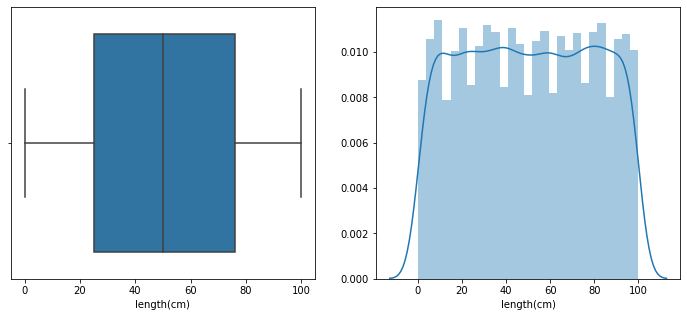

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['length(cm)'], ax=ax[0])
sns.distplot(train_df['length(cm)'], ax=ax[1])

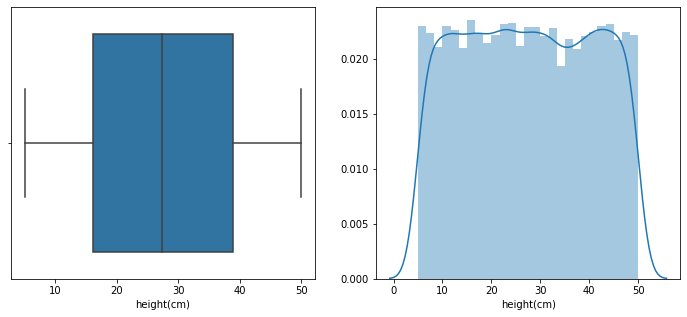

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['height(cm)'], ax=ax[0])
sns.distplot(train_df['height(cm)'], ax=ax[1])

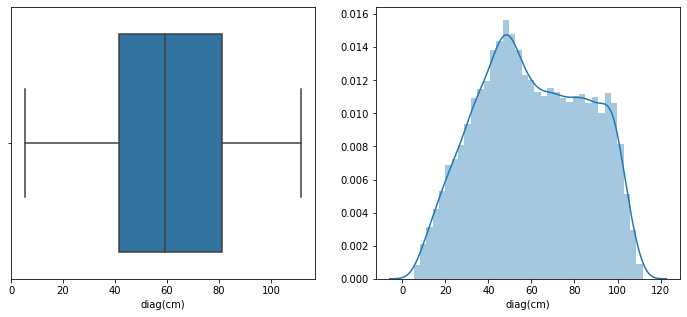

In [31]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['diag(cm)'], ax=ax[0])
sns.distplot(train_df['diag(cm)'], ax=ax[1])

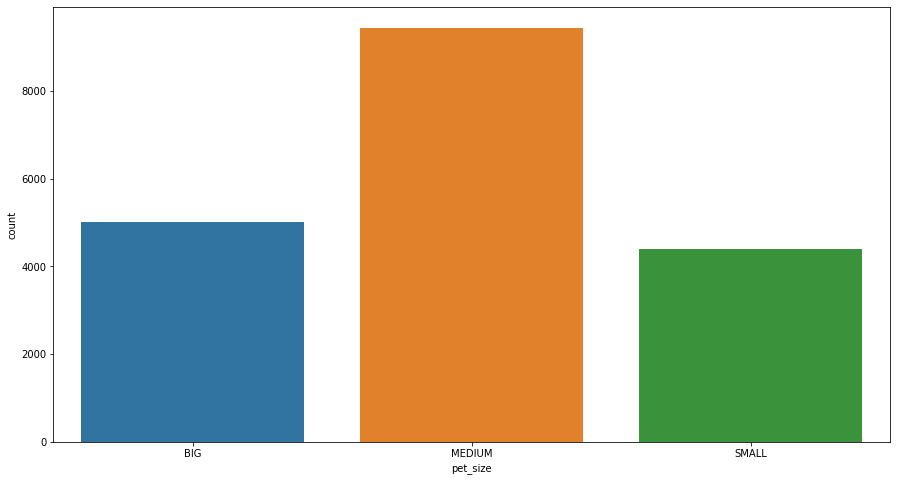

In [32]:
plt.figure(figsize=(15, 8))
sns.countplot(x="pet_size", data=train_df)

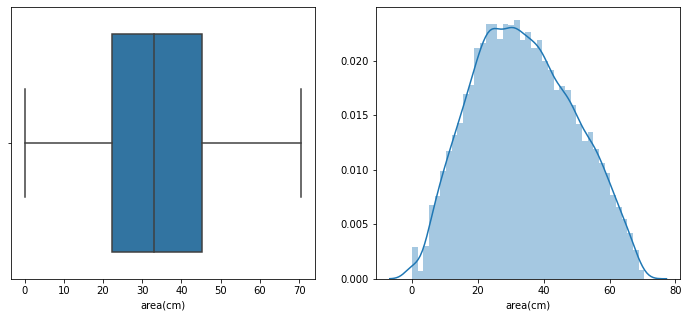

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['area(cm)'], ax=ax[0])
sns.distplot(train_df['area(cm)'], ax=ax[1])

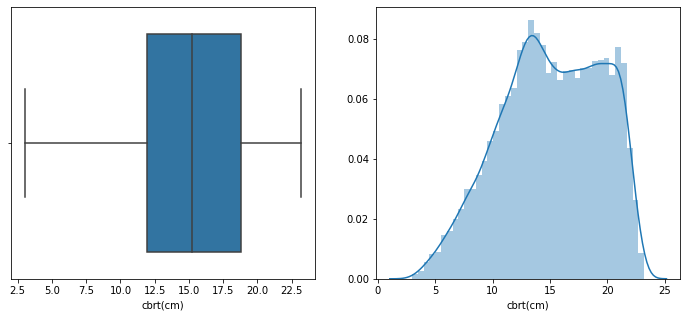

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['cbrt(cm)'], ax=ax[0])
sns.distplot(train_df['cbrt(cm)'], ax=ax[1])

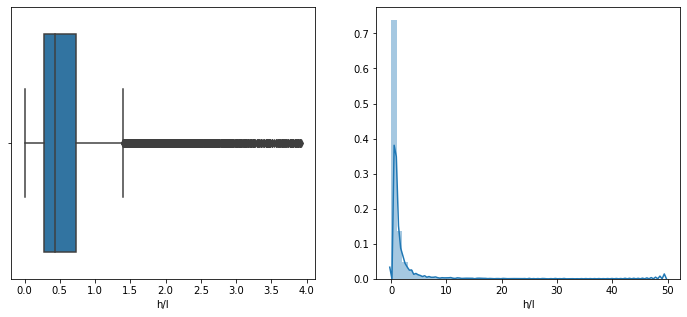

In [23]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(np.log1p(train_df['h/l']), ax=ax[0])
sns.distplot(train_df['h/l'], ax=ax[1])

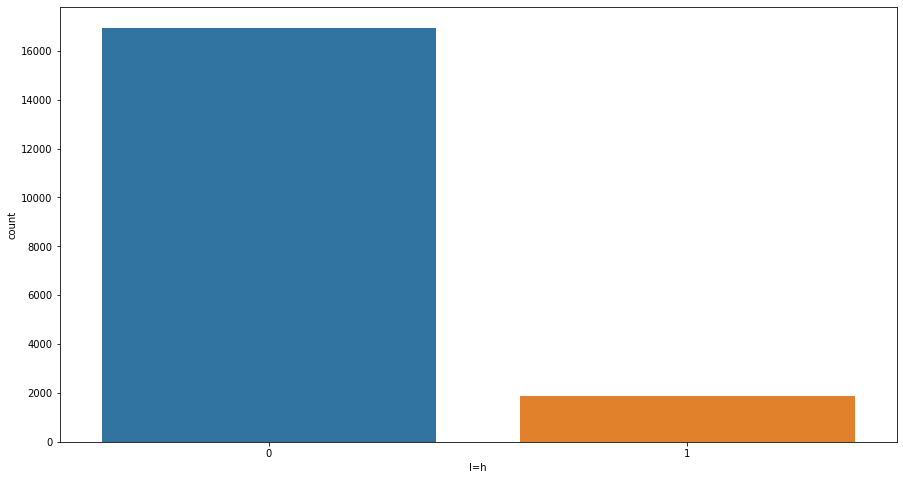

In [25]:
plt.figure(figsize=(15, 8))
sns.countplot(x="l=h", data=train_df)

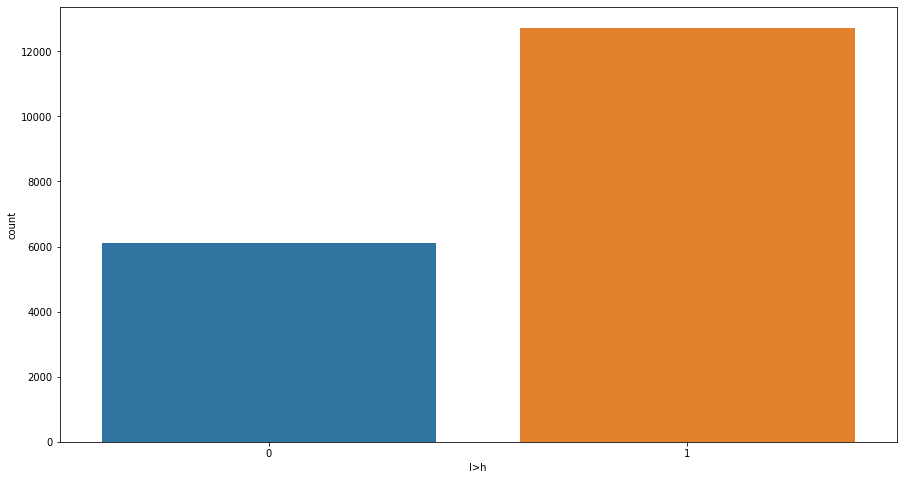

In [26]:
plt.figure(figsize=(15, 8))
sns.countplot(x="l>h", data=train_df)

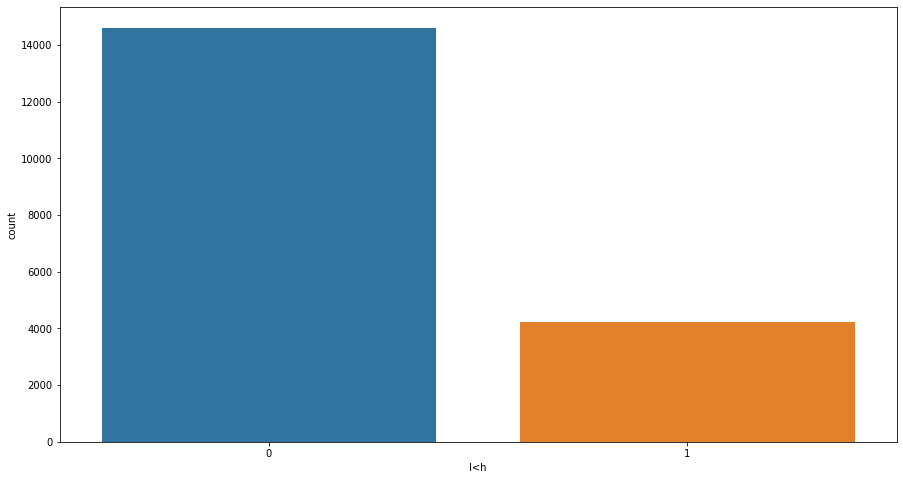

In [27]:
plt.figure(figsize=(15, 8))
sns.countplot(x="l<h", data=train_df)

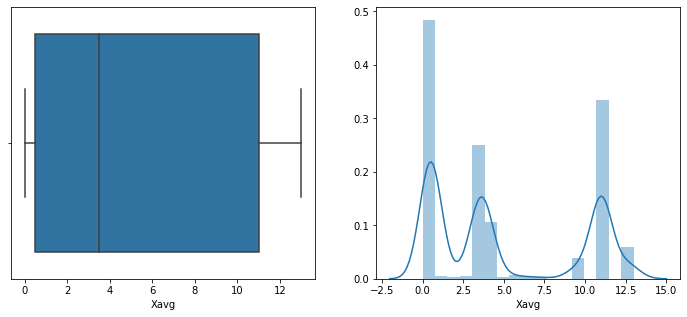

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['Xavg'], ax=ax[0])
sns.distplot(train_df['Xavg'], ax=ax[1])

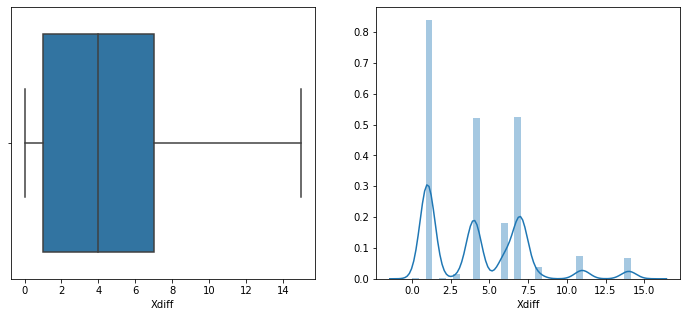

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['Xdiff'], ax=ax[0])
sns.distplot(train_df['Xdiff'], ax=ax[1])

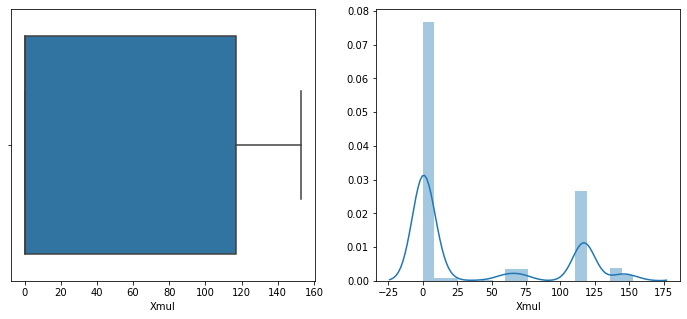

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['Xmul'], ax=ax[0])
sns.distplot(train_df['Xmul'], ax=ax[1])

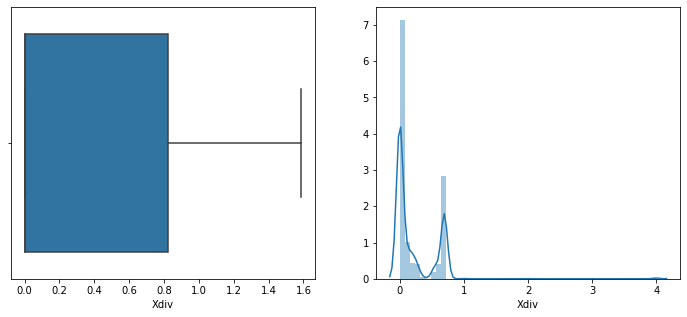

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(np.cbrt(train_df['Xdiv']), ax=ax[0])
sns.distplot(train_df['Xdiv'], ax=ax[1])

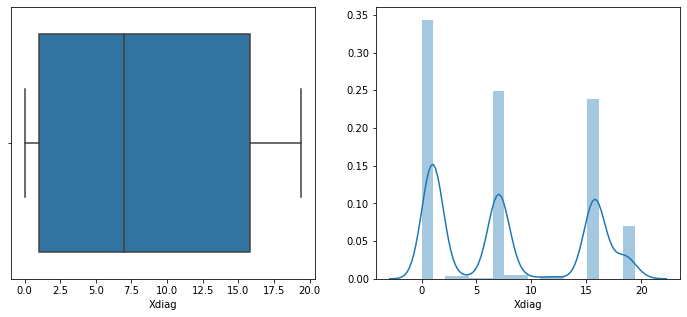

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['Xdiag'], ax=ax[0])
sns.distplot(train_df['Xdiag'], ax=ax[1])

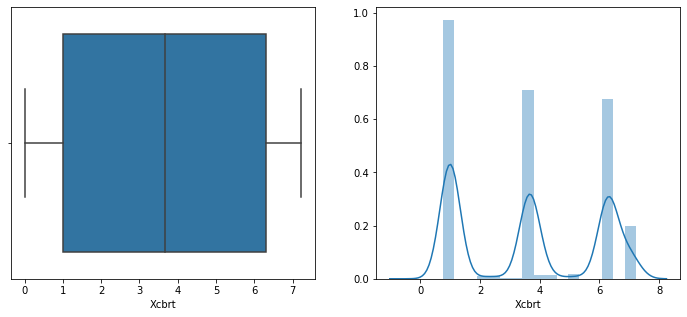

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['Xcbrt'], ax=ax[0])
sns.distplot(train_df['Xcbrt'], ax=ax[1])

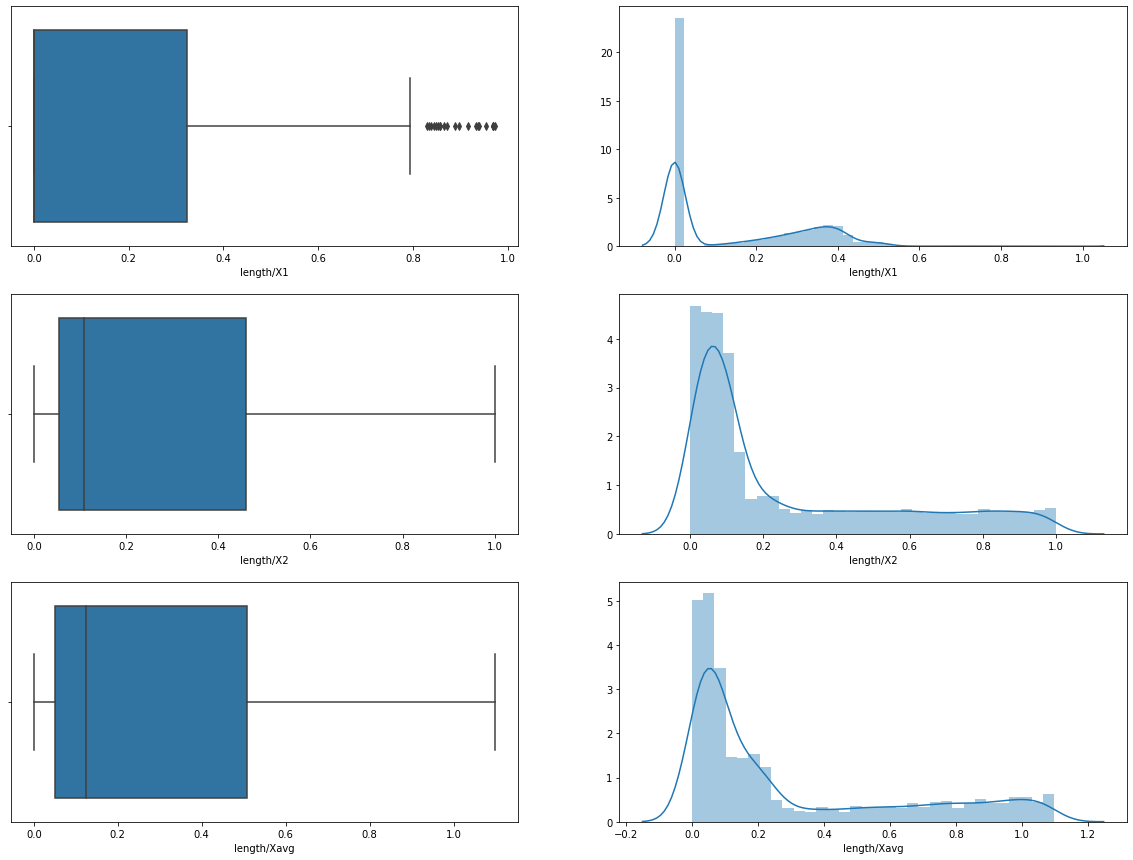

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(20, 15))
sns.boxplot(np.cbrt(train_df['length/X1']), ax=ax[0][0])
sns.distplot(np.cbrt(train_df['length/X1']), ax=ax[0][1])
sns.boxplot(train_df['length/X2'], ax=ax[1][0])
sns.distplot(train_df['length/X2'], ax=ax[1][1])
sns.boxplot(np.log1p(train_df['length/Xavg']), ax=ax[2][0])
sns.distplot(np.log1p(train_df['length/Xavg']), ax=ax[2][1])

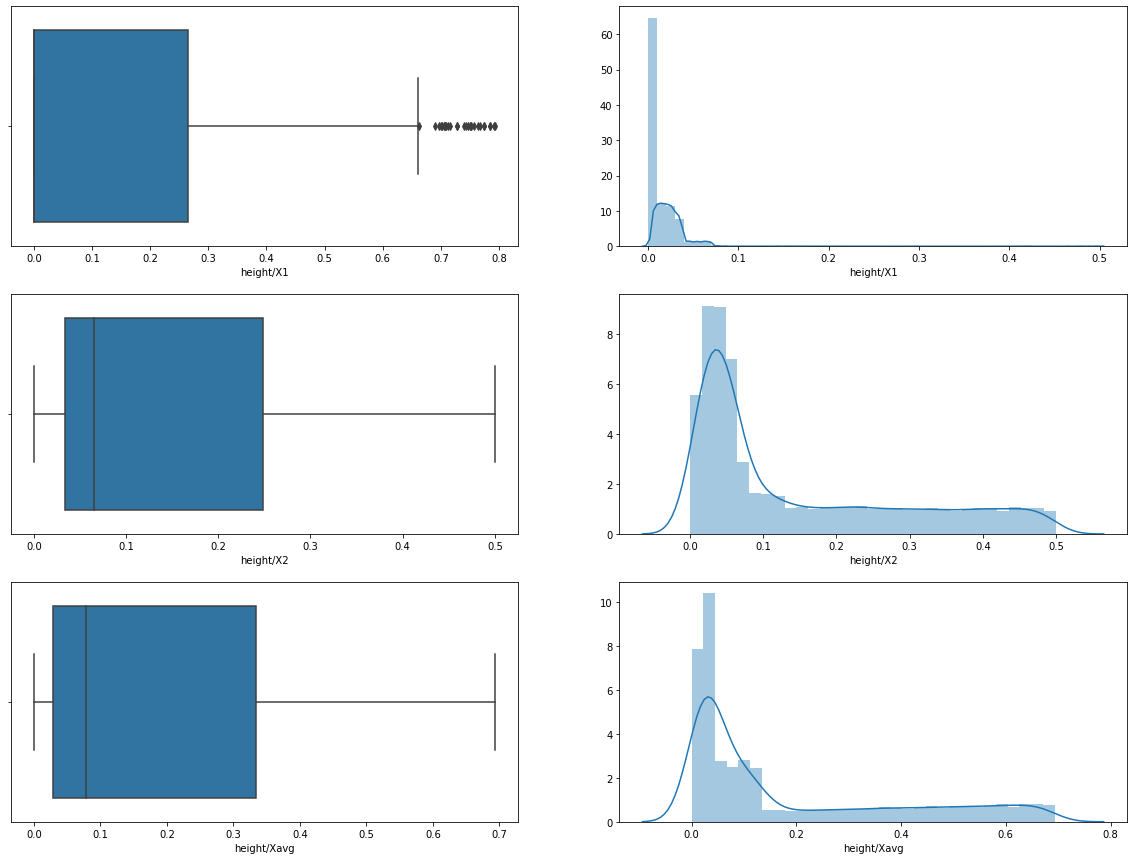

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(20, 15))
sns.boxplot(np.cbrt(train_df['height/X1']), ax=ax[0][0])
sns.distplot(np.cbrt(train_df['height/X1']), ax=ax[0][1])
sns.boxplot(train_df['height/X2'], ax=ax[1][0])
sns.distplot(train_df['height/X2'], ax=ax[1][1])
sns.boxplot(np.log1p(train_df['height/Xavg']), ax=ax[2][0])
sns.distplot(np.log1p(train_df['height/Xavg']), ax=ax[2][1])

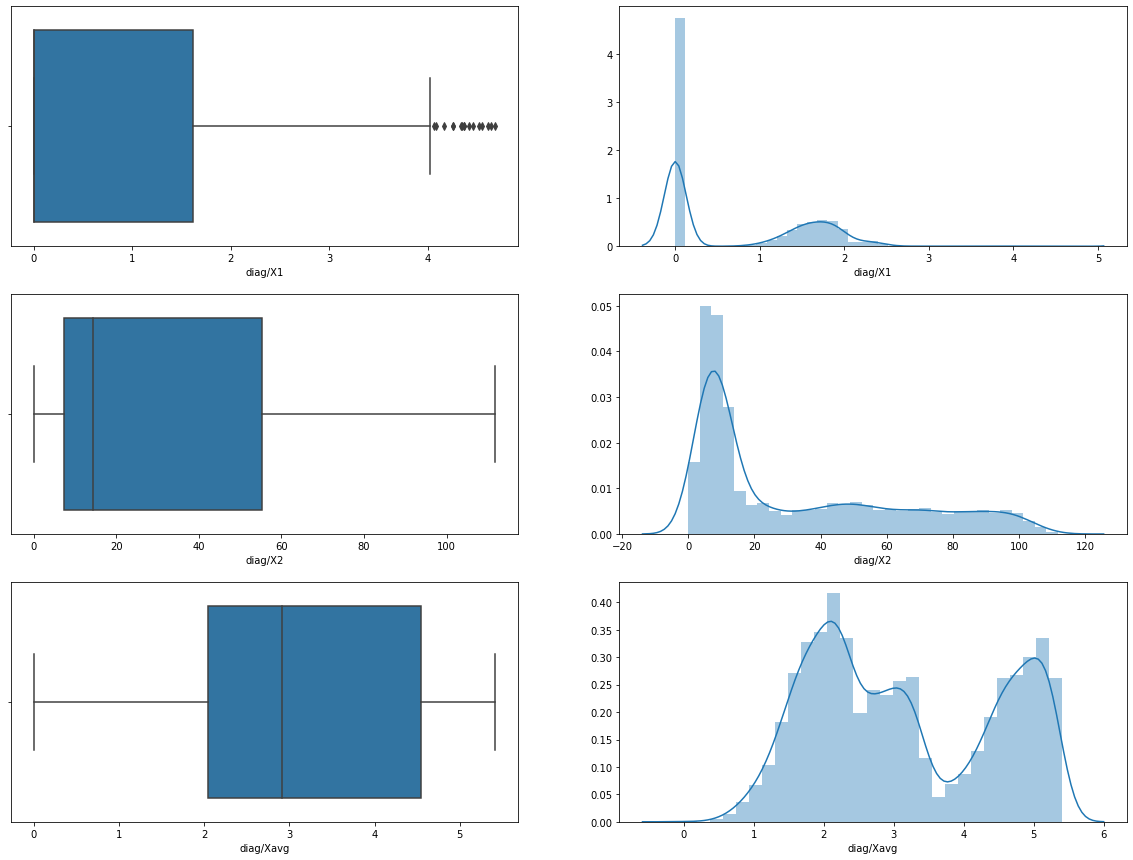

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(20, 15))
sns.boxplot(np.cbrt(train_df['diag/X1']), ax=ax[0][0])
sns.distplot(np.cbrt(train_df['diag/X1']), ax=ax[0][1])
sns.boxplot(train_df['diag/X2'], ax=ax[1][0])
sns.distplot(train_df['diag/X2'], ax=ax[1][1])
sns.boxplot(np.log1p(train_df['diag/Xavg']), ax=ax[2][0])
sns.distplot(np.log1p(train_df['diag/Xavg']), ax=ax[2][1])

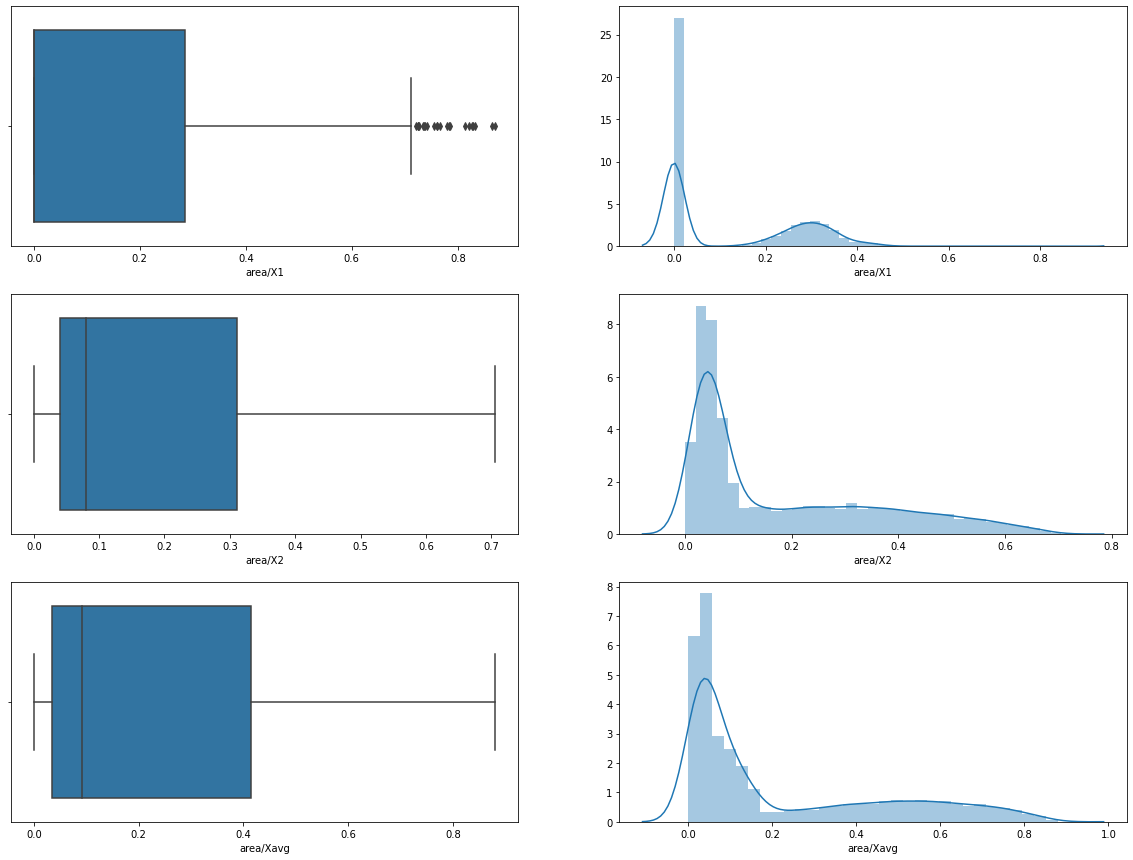

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(20, 15))
sns.boxplot(np.cbrt(train_df['area/X1']), ax=ax[0][0])
sns.distplot(np.cbrt(train_df['area/X1']), ax=ax[0][1])
sns.boxplot(train_df['area/X2'], ax=ax[1][0])
sns.distplot(train_df['area/X2'], ax=ax[1][1])
sns.boxplot(np.log1p(train_df['area/Xavg']), ax=ax[2][0])
sns.distplot(np.log1p(train_df['area/Xavg']), ax=ax[2][1])

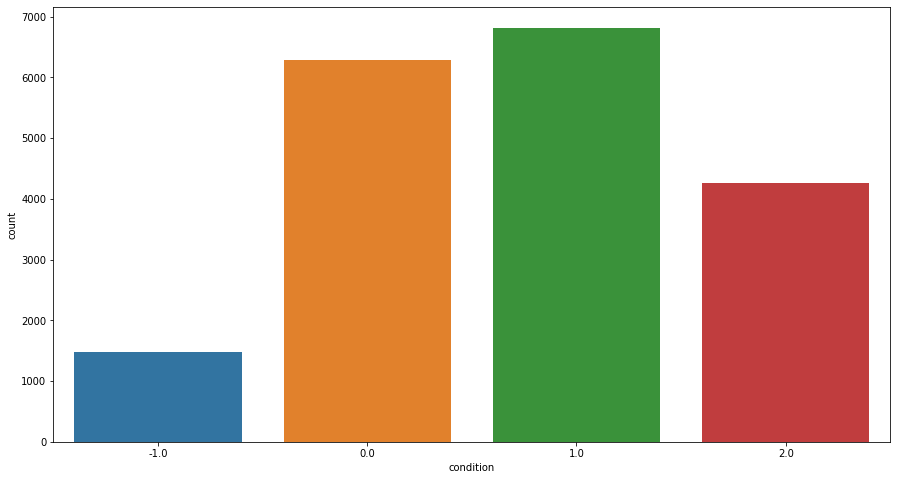

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x="condition", data=train_df)

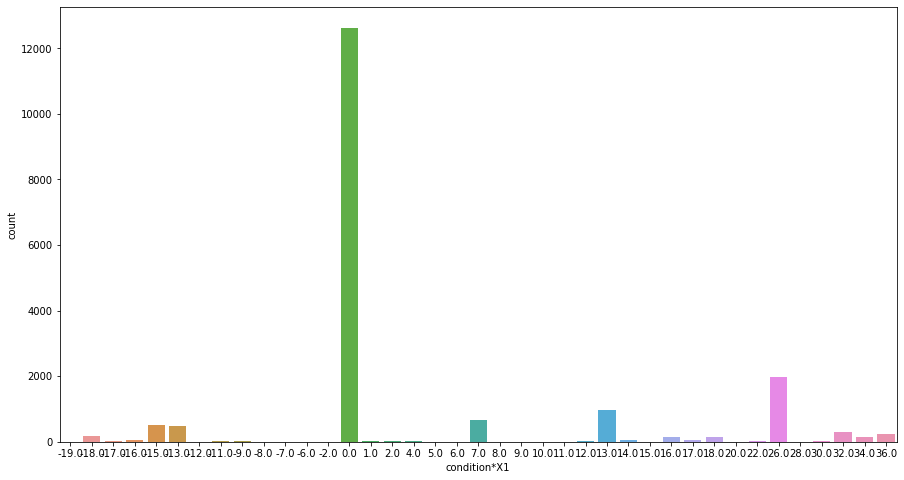

In [11]:
plt.figure(figsize=(15, 8))
sns.countplot(x="condition*X1", data=train_df)

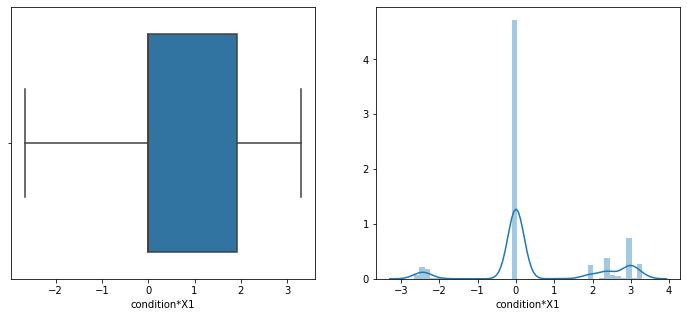

In [17]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(np.cbrt(train_df['condition*X1']), ax=ax[0])
sns.distplot(np.cbrt(train_df['condition*X1']), ax=ax[1])

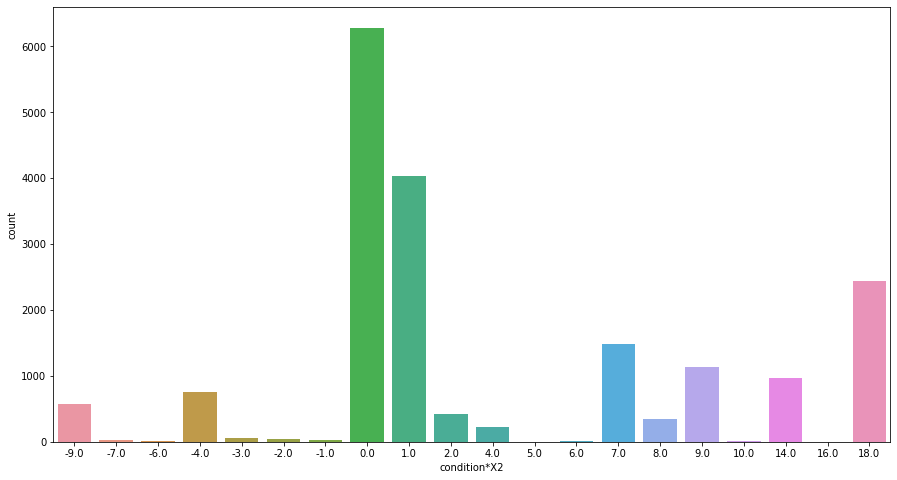

In [9]:
plt.figure(figsize=(15, 8))
sns.countplot(x="condition*X2", data=train_df)

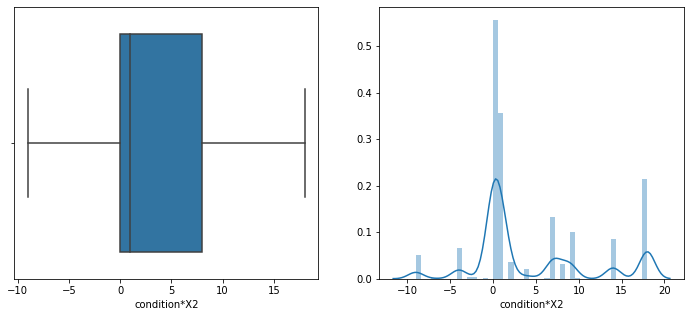

In [13]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(train_df['condition*X2'], ax=ax[0])
sns.distplot(train_df['condition*X2'], ax=ax[1])

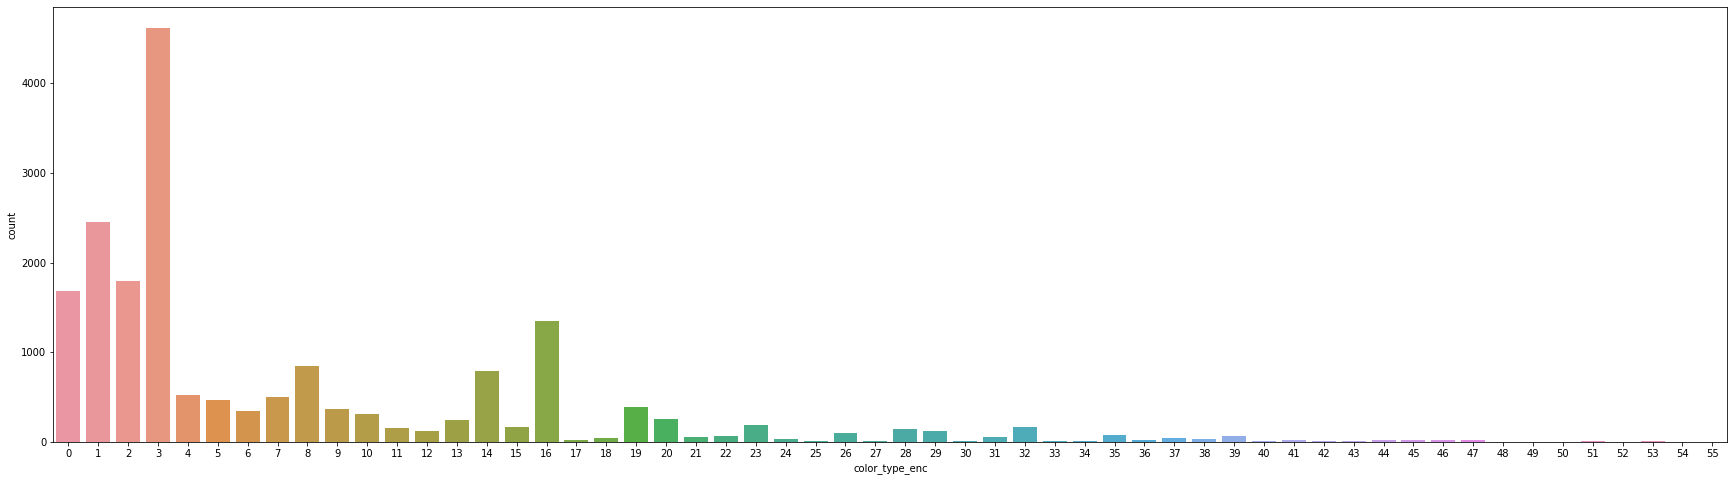

In [ ]:
plt.figure(figsize=(30, 8))
sns.countplot(x="color_type_enc", data=train_df)

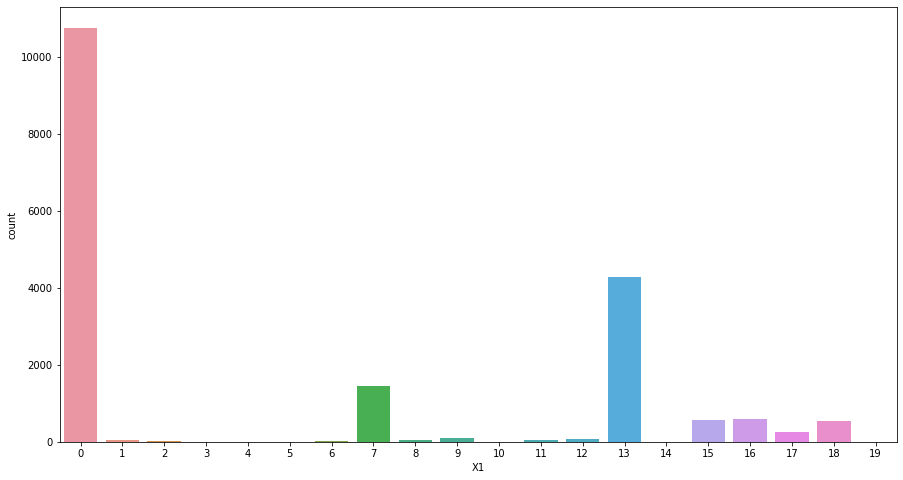

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x="X1", data=train_df)

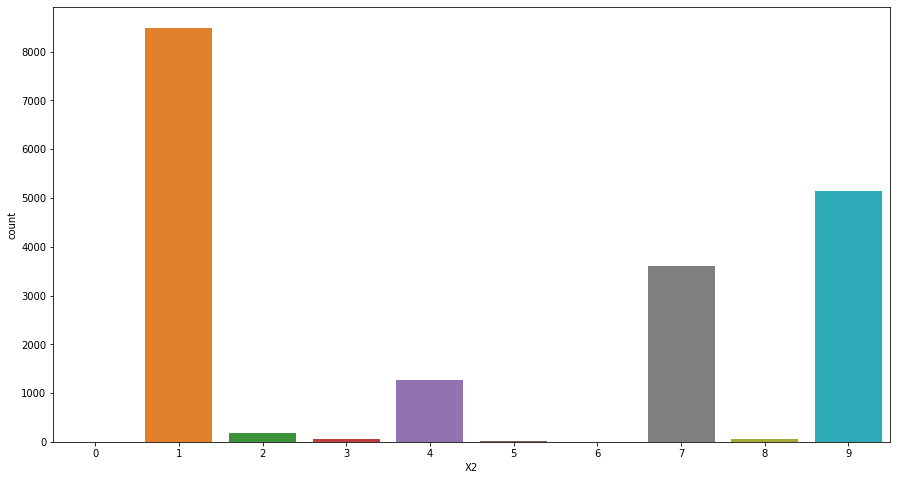

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x="X2", data=train_df)

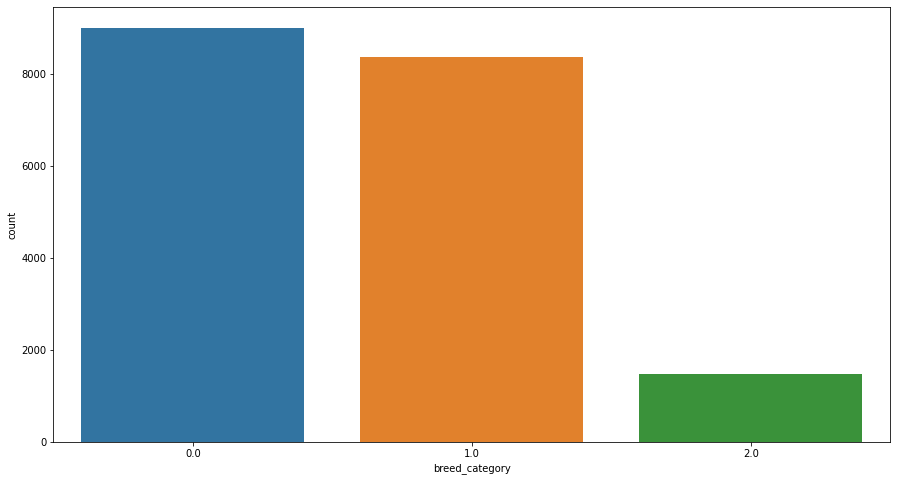

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x="breed_category", data=train_df)

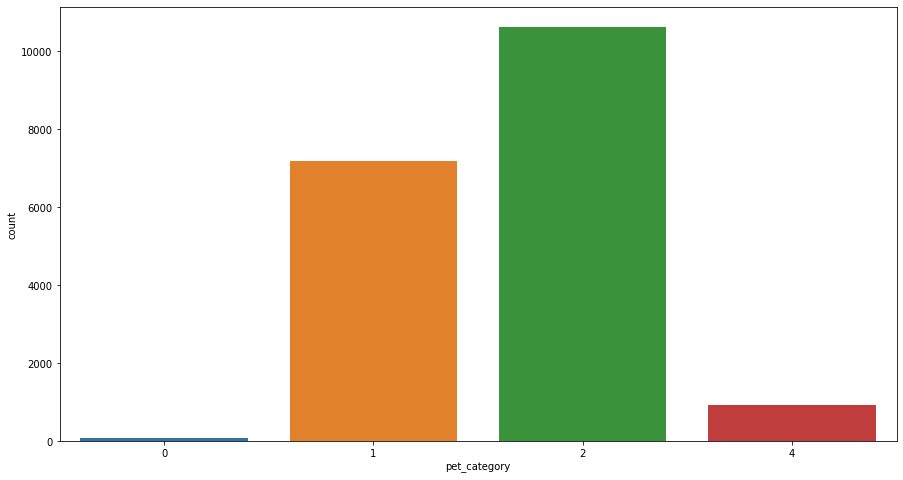

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x="pet_category", data=train_df)

### Feature Selection

#### Breed Category

In [ ]:
# Correlation Analysis
df_corr = abs(train_df.corr())
df_corr = df_corr['breed_category']
df_corr = pd.DataFrame(df_corr.values, train_df.columns).reset_index()

df_corr.columns = ['Feature', 'Corr']
#df_corr = df_corr[df_corr['Corr'] > 0.01]
df_corr = df_corr.sort_values(by='Corr', ascending=False)[1:]
#df_corr = df_corr.head(50)
#print(df_corr.shape)


for index, row in df_corr.iterrows(): 
    print("{} -> {}".format(row["Feature"].ljust(30), row["Corr"]))


#df_corr.head()

condition_odd_even_ODD         -> 0.7183047797100703
condition                      -> 0.6699532358855579
condition_odd_even_NONE        -> 0.6481241270147604
condition_odd_even_EVEN        -> 0.3444006522725904
X2_odd_even_EVEN               -> 0.3152017015758547
X2_odd_even_ODD                -> 0.3152017015758547
X1                             -> 0.2407288958847133
pet_category                   -> 0.20923016781983844
Xdiag                          -> 0.2011700701557062
Xavg                           -> 0.19442483337692837
Xcbrt                          -> 0.19262167807979885
Xdiff                          -> 0.19240105889961928
X1_odd_even_ODD                -> 0.17559791175188277
X1_odd_even_EVEN               -> 0.17559791175188277
Xmul                           -> 0.15523320164603022
Xdiv                           -> 0.10473552494600598
color_family_red               -> 0.1031014592880267
dt_diff_hrs                    -> 0.10278274613821917
dt_diff_mnths                  -> 0.1

In [ ]:
# Univariate Selection
y = train_df['breed_category']
X = train_df.drop(['breed_category'], axis=1)

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores = featureScores.sort_values(by='Score', ascending=False)  #.head(157)
#print(featureScores.shape)


for index, row in featureScores.iterrows(): 
    print("{} -> {}".format(row["Specs"].ljust(30), row["Score"]))


#featureScores.head()

condition_odd_even_NONE        -> inf
condition_odd_even_EVEN        -> 17032.565553288732
condition_odd_even_ODD         -> 15370.785090661791
condition                      -> 8631.826620518083
X2_odd_even_EVEN               -> 3106.638163348113
X2_odd_even_ODD                -> 3106.6381633480833
pet_category                   -> 1419.7988746364044
X1                             -> 1278.8737398823703
Xdiff                          -> 1116.6198594119844
Xdiag                          -> 981.9592964435096
Xcbrt                          -> 917.730461456782
Xavg                           -> 870.2632210476867
X1_odd_even_EVEN               -> 575.0847337532846
X1_odd_even_ODD                -> 575.0847337532823
Xmul                           -> 470.12875121318973
Xdiv                           -> 205.26764703803383
color_family_calico            -> 186.80568927492786
color_family_red               -> 175.88968668195787
dt_diff_min                    -> 172.0635162058549
dt_diff_weeks    

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [ ]:
# Common features based on correlation and ANOVA
idx1 = pd.Index(df_corr['Feature'])
idx2 = pd.Index(featureScores['Specs'])
features_list = idx1.intersection(idx2)
print(len(features_list))
features_list

144


Index(['condition_odd_even_ODD', 'condition_1.0', 'condition_odd_even_NONE',
       'condition_-1.0', 'condition_0.0', 'X1_15', 'condition_odd_even_EVEN',
       'X2_4', 'X2_odd_even_EVEN', 'X2_odd_even_ODD',
       ...
       's_x', 'X1_1', 'color_type_Brown Tabby', 'b_y', 'c_x',
       'color_type_Blue Merle', 'lst_dt_minute', 'lst_dt_day_weekend', 'p_x',
       'color_type_Blue Cream'],
      dtype='object', length=144)

#### Pet Category

In [ ]:
# Correlation Analysis
df_corr = abs(train_df.corr())
df_corr = df_corr['pet_category']
df_corr = pd.DataFrame(df_corr.values, train_df.columns).reset_index()

df_corr.columns = ['Feature', 'Corr']
#df_corr = df_corr[df_corr['Corr'] > 0.01]
df_corr = df_corr.sort_values(by='Corr', ascending=False)[1:]
#df_corr = df_corr.head(50)
#print(df_corr.shape)


for index, row in df_corr.iterrows(): 
    print("{} -> {}".format(row["Feature"].ljust(30), row["Corr"]))


#df_corr.head()

color_type_num_words           -> 0.40329823552207406
color_type_num_chars           -> 0.3808370097775924
X2_odd_even_ODD                -> 0.36191221320556527
X2_odd_even_EVEN               -> 0.36191221320556527
condition_odd_even_NONE        -> 0.3605595241285098
condition                      -> 0.22847898830594238
color_family_orange            -> 0.20986215596373742
breed_category                 -> 0.20923016781983844
Xdiff                          -> 0.20163904014335465
condition_odd_even_EVEN        -> 0.16774175664302662
color_family_brown             -> 0.14391648451750153
color_family_calico            -> 0.12875515837709967
Xmul                           -> 0.1256504696931706
color_family_blue              -> 0.12423575960047041
iss_dt_quarter                 -> 0.11878762272235083
iss_dt_month                   -> 0.10906212981708237
iss_dt_day_year                -> 0.10765307328350085
iss_dt_week                    -> 0.1062405402495145
Xdiv                           -

In [ ]:
# Univariate Selection
y = train_df['pet_category']
X = train_df.drop(['pet_category'], axis=1)

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores = featureScores.sort_values(by='Score', ascending=False).head(166)
print(featureScores.shape)

'''
for index, row in featureScores.iterrows(): 
    print("{} -> {}".format(row["Specs"].ljust(30), row["Score"]))
'''

featureScores.head()

(166, 2)


,Specs,Score
109,X1_15,6935.012139
36,condition_odd_even_NONE,5141.262658
31,condition_-1.0,5141.262658
120,X2_4,3587.809184
127,X2_odd_even_ODD,3052.707768


In [ ]:
# Common features based on correlation and ANOVA
idx1 = pd.Index(df_corr['Feature'])
idx2 = pd.Index(featureScores['Specs'])
features_list = idx1.intersection(idx2)
print(len(features_list))
features_list

151


Index(['X1_15', ' _x', 'color_type_num_words', ' _y', 'X2_4', 'y_y',
       'color_type_num_chars', 'X2_odd_even_ODD', 'X2_odd_even_EVEN',
       'condition_odd_even_NONE',
       ...
       'X1_19', 'lst_dt_day_weekend', 'X1_1', 'i_x', 'o_x',
       'color_type_Brown Merle', 'color_type_Orange', 'r_y', 'color_type_Gold',
       'iss_dt_day_month'],
      dtype='object', length=151)